# E-150 Grad
**Harvard University**<br>


Import libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import Lasso as Lasso_Reg
from statsmodels.regression.linear_model import OLS
import sklearn.preprocessing as Preprocessing
import itertools as it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import scipy as sp
from itertools import combinations
%matplotlib inline

[Tiwari, Sanjay]

**All data sets can be found in the ``datasets`` folder and are in comma separated value (CSV) format**

 Variable selection and regularization


###  Analyze correlation among predictors
- By visually inspecting the data set, do find that some of the predictors are correlated amongst themselves?


- Compute the cofficient of correlation between each pair of predictors, and visualize the matrix of correlation coefficients using a heat map. Do the predictors fall naturally into groups based on the correlation values?


- To select a minimal subset of predictors based on the correlation information in order to build a good regression model, how many predictors to pick, and which ones to choose? 

In [3]:
# Load data
#data = np.loadtxt('communities-nohead.csv', delimiter=',')
data = np.loadtxt('communities-nonull.csv', delimiter=',', skiprows=1)

# Split predictors and response
x = data[:, :-1]
y = data[:, -1]

df = pd.DataFrame(data)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,117,118,119,120,121,122,123,124,125,126
0,8.0,0.0,0.0,1.0,0.19,0.33,0.02,0.90,0.12,0.17,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53.0,0.0,0.0,1.0,0.00,0.16,0.12,0.74,0.45,0.07,...,0.02,0.12,0.45,0.00,0.00,0.0,0.0,0.00,0.00,0.67
2,24.0,0.0,0.0,1.0,0.00,0.42,0.49,0.56,0.17,0.04,...,0.01,0.21,0.02,0.00,0.00,0.0,0.0,0.00,0.00,0.43
3,34.0,5.0,81440.0,1.0,0.04,0.77,1.00,0.08,0.12,0.10,...,0.02,0.39,0.28,0.00,0.00,0.0,0.0,0.00,0.00,0.12
4,42.0,95.0,6096.0,1.0,0.01,0.55,0.02,0.95,0.09,0.05,...,0.04,0.09,0.02,0.00,0.00,0.0,0.0,0.00,0.00,0.03


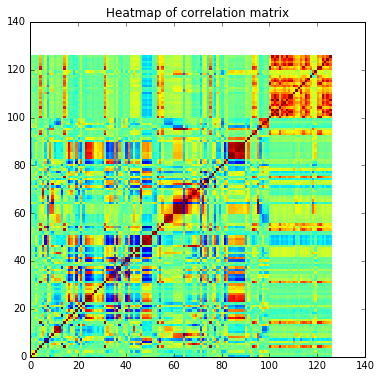

In [3]:
# Compute matrix of correlation coefficients

corr_matrix = np.corrcoef(x.T)

# Display heat map 
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.pcolormesh(corr_matrix)

ax.set_title('Heatmap of correlation matrix')

plt.show()

Variables in RGB colors show stronger corelation from +1 (Red) to 0 (GREEN) to -1 (Blue) on coefficient values. 

The following groups seems to show stronger relationships:  

Very Strong [0,1,2],[4,5,6] So only choose one from each group.

Weak[7,8,9]

A stronger relationship may help us to find which ones we can ignore and only evaluate one of the variables and not have to account all from the same relationship groups.

How many predictors to choose, and which ones to choose? 

Based on the analysis done above I will choose 1+1+3 coefficients from each groups, and as following to avoid any colinearity:

[0],[4],[7,8,9]

###  Selecting minimal subset of predictors

- Applying the variable selection methods discussed in class to choose a minimal subset of predictors that yield high prediction accuracy:
    
    - Exhaustive search
    
    - Step-wise forward selection **or** Step-wise backward selection  

&emsp;&nbsp;&nbsp; In each method, used the Bayesian Information Criterion (BIC) to choose the subset size

**Note**: Using the `statsmodels`'s `OLS` module to fit a linear regression model and evaluate BIC. Y

In [4]:
min_bic = 1e10 # set some initial large value for min BIC score
best_subset = [] # best subset of predictors

# Create all possible subsets of the set of 10 predictors
predictor_set = set(range(10)) # predictor set = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

# Repeat for every possible size of subset
for size_k in range(10): 
    # Create all possible subsets of size 'size', 
    # using the 'combination' function from the 'itertools' library
    subsets_of_size_k = it.combinations(predictor_set, size_k + 1) 
    
    max_r_squared = -1e10 # set some initial small value for max R^2 score
    best_k_subset = [] # best subset of predictors of size k
    
    # Iterate over all subsets of our predictor set
    for predictor_subset in subsets_of_size_k:    
        # Use only a subset of predictors in the training data
        x_subset = x[:, predictor_subset]

        # Fit and evaluate R^2
        model = OLS(y, x_subset)
        results = model.fit()
        r_squared = results.rsquared
        
        # Update max R^2 and best predictor subset of size k
        # If current predictor subset has a higher R^2 score than that of the best subset 
        # we've found so far, remember the current predictor subset as the best!
        if(r_squared > max_r_squared): 
            max_r_squared = r_squared
            best_k_subset = predictor_subset[:]
                

    # Use only the best subset of size k for the predictors
    x_subset = x[:, best_k_subset]
        
    # Fit and evaluate BIC of the best subset of size k
    model = OLS(y, x_subset)
    results = model.fit()
    bic = results.bic
    
    # Update minimum BIC and best predictor subset
    # If current predictor has a lower BIC score than that of the best subset 
    # we've found so far, remember the current predictor as the best!
    if(bic < min_bic): 
        min_bic = bic
        best_subset = best_k_subset[:]
    
print('Best subset by exhaustive search:')
print sorted(best_subset)

Best subset by exhaustive search:
[0, 2, 4, 5, 6, 7, 9]


In [5]:
###  Step-wise Backward Selection
d = x.shape[1] # total no. of predictors

# Keep track of current set of chosen predictors
current_predictors = range(d)

# First, fit and evaluate BIC using all 'd' number of predictors
model = OLS(y, x)
results = model.fit()
bic_all = results.bic

# Set the minimum BIC score, initially, to the BIC score using all 'd' predictors
global_min_bic = bic_all
# Keep track of the best subset of predictors
best_subset = [] 

# Iterate over all possible subset sizes, d predictors to 1 predictor
for size in range(d - 1, 1, -1): # stop before 0 to avoid choosing an empty set of predictors
    max_r_squared = -1e10 # set some initial small value for max R^2
    worst_predictor = -1 # set some throwaway initial number for the worst predictor to remove
    bic_without_worst_predictor = 1e10 # set some initial large value for min BIC score  
        
    # Iterate over current set of predictors (for potential elimination)
    for i in current_predictors:
        # Create copy of current predictors, and remove predictor 'i'
        temp = current_predictors[:]
        temp.remove(i)
                                    
        # Use only a subset of predictors in the training data
        x_subset = x[:, temp]
        
        # Fit and evaluate R^2
        model = OLS(y, x_subset)
        results = model.fit()
        r_squared = results.rsquared
        
        # Check if we get a higher R^2 value than than current max R^2, if so, update
        if(r_squared > max_r_squared):
            max_r_squared = r_squared
            worst_predictor = i
            bic_without_worst_predictor = results.bic
          
    # Remove worst predictor from current set of predictors
    current_predictors.remove(worst_predictor)
    
    # Check if BIC for the predictor we just removed is lower than 
    # the global minimum across all subset of predictors
    if(bic_without_worst_predictor < global_min_bic):
        best_subset = current_predictors[:]
        global_min_bic = bic_without_worst_predictor
    
print 'Step-wise backward subset selection:'
print sorted(best_subset)

Step-wise backward subset selection:
[1, 6, 15, 19, 20, 42, 54, 55, 71, 72, 75, 86, 89, 92, 94, 106]


Do the chosen subsets match the ones we picked using the correlation matrix?

From Part 1 we found the following sets to be most useful : [0],[4 or 5],[7,8,9]

With both Backward and exhaustive search we see the results are very much in the lines and avoiding strong collinearity of predictors.

So yes answers and subsets mostly match from part a except the choise 4 or 5.

### Applying Lasso and Ridge regression

- Apply Lasso regression with regularization parameter $\lambda = 0.01$ and fit a regression model.

- Apply Ridge regression with regularization parameter $\lambda = 0.01$ and fit a regression model.

**Note**: Using the `statsmodels` or `sklearn` to perform Lasso and Ridge regression.

In [6]:
# Lasso regression
reg = Lasso_Reg(alpha = 0.01)
reg.fit(x, y)
coefficients = reg.coef_

print 'Lasso:'
print 'Coefficients:', coefficients
print  'Predictors with non-zero coefficients:', [i for i, item in enumerate(coefficients) if abs(item) > 0]

Lasso:
Coefficients: [ -1.48975445e-03  -1.18791872e-05  -1.08937457e-06  -9.72757750e-04
   0.00000000e+00  -0.00000000e+00   1.22184427e-03  -9.01861179e-02
  -0.00000000e+00   0.00000000e+00  -0.00000000e+00  -0.00000000e+00
  -0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -0.00000000e+00  -0.00000000e+00
   0.00000000e+00   0.00000000e+00  -0.00000000e+00  -0.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -0.00000000e+00  -0.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00  -0.00000000e+00
   0.00000000e+00  -0.00000000e+00  -0.00000000e+00  -0.00000000e+00
   0.00000000e+00  -0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00  -0.00000000e+00
  -1.45603969e-01  -0.00000000e+00  -0.00000000e+00  -0.00000000e+00
  -0.00000000e+00   0.00000000e+00   3.20250277e-01   0.00000000e+00
   0.00000000



We can deduce [0 or 2],[4],[7,8,9] which lead to answers it gave us similar sets except choosing between 0 or 2.

In [7]:
# Ridge regression: Fit and evaluate 
reg = Ridge_Reg(alpha = 0.01)
reg.fit(x, y)
coefficients = reg.coef_

print 'Ridge:'
print 'Coefficients:', coefficients
print 'Predictors with non-zero coefficients:', [i for i, item in enumerate(coefficients) if abs(item) > 0]

Ridge:
Coefficients: [ -5.25889786e-04  -1.38839474e-04  -2.55862186e-07  -1.52310137e-03
   2.57249795e-01  -8.22733358e-03   1.68838020e-01  -6.94160812e-02
  -3.42665328e-02   5.10469641e-02   1.19160247e-01  -2.52347321e-01
  -1.47215981e-01   1.81394007e-02  -3.25464724e-01   5.01801726e-02
  -1.94835157e-01  -1.76052174e-01   4.17401374e-02  -1.51094937e-01
   9.62730712e-02   1.22668946e-02  -8.55159420e-02   2.82960319e-01
   1.75474140e-01  -4.04948564e-01  -3.43851643e-02  -3.43971528e-02
   1.93535129e-02   4.36510520e-02   3.19031244e-02   4.38891555e-02
  -1.87786364e-01  -9.00355144e-02   5.72163628e-02   3.18690050e-02
  -4.70983583e-03   2.56807803e-01  -6.21061531e-02  -5.41490844e-03
   7.42581648e-02   1.08495504e-01   4.05746069e-01   2.34307849e-01
   3.31846613e-02  -4.35799872e-01  -1.49765554e-01  -4.52395845e-03
  -3.19877998e-01  -2.93637443e-02   4.12361040e-04   4.82740468e-02
  -1.81482561e-01  -1.25553685e-01   1.23142449e-01  -2.19010148e-01
   2.09189526

Is there a difference between the model parameters we obtained different and those obtained from Lasso regression?

Yes indeed we have all the predictors in Ridge regression with non-zero coefficients for such the lambda value. 
This make sense why Lasso was able to shrink coefficients for the given lambda value with Regularization with L1 approach of Lasso it is able to completely eliminate a coefficient as the RSS can reach minimization goal of Regularization and coefficient can be zero where RSS plot can touch the absolute value of (labmda.Sigma(ABS(Betas))) curve touching zero. 
Where as Ridge may have minimized (shrunk) values of coefficients but could not completetly eliminate in  L2 Regularization.

Identify the predictors that are assigned non-zero coefficients:

Since all them are chosen by Ridge these are listed above.
Do these correspond to the correlation matrix?
From part a we can deduce [0 or 2],[4],[7,8,9] this does not match with Ridge regression sets.


First three coefficients in Ridge regression are 0.49399586, -0.88861864 and 0.12844832, two of them are positive and would give slightly weak slope but second one is above 0.8 and negative thus give reverse relation. Since these are highly correlated the net effect may not give us strong response out the fit.
Do you observe the same with Lasso regression? 
We observer first three coeefcients are 0, 0 and 0.04466466, this is different than that of the Ridge coefficients.
Give an explanation for your observation.
The net effect of both Regularization would have same effect, in case of Ridge it tends to produce a net weak response from the predictors. Whereas Lass will give us a weak response because the coefficient is rather very small only ~0.045. The results for both may be same.

 Cross-validation and Bootstrapping

###  Encode categorical attributes and fill missing values
Identify the categorical attributes in the data. Replace their values with the one-hot binary encoding. 


In [9]:
pd_auto_data = pd.read_csv("communities-nonull.csv")
#pd_auto_data.fillna(0)


In [3]:
#pd_auto_cate = pd.get_dummies(pd_auto_data) 
pd_auto_cate = pd_auto_data.drop(['state', 'county', 'community', 'fold'], axis=1) 
#pd_auto_cate = pd_auto_data.drop(['state', 'county', 'community', 'fold'], axis=1) 
print pd_auto_cate.shape
#pd_auto_cate.describe
pd_auto_cate.head(1)

(1994, 123)


,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.9,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.2,0.06,0.04,0.9,0.5,0.32,0.14,0.2


###  Apply regular linear regression
- Split the data set into train and test sets, with the first 25% of the data for training and the remaining for testing.  


- Use regular linear regression to fit a model to the training set and evaluate the R^2 score of the fitted model on both the training and test sets. What do you observe about these values?



- Is there a need for regularization while fitting a linear model to this data set?

**Note**: Using the `statsmodels` or `sklearn` to fit a linear regression model and evaluate the fits.

In [45]:
from sklearn.cross_validation import train_test_split

X = pd_auto_cate.drop('ViolentCrimesPerPop', axis=1) 
y = pd_auto_cate['ViolentCrimesPerPop']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.25)    

model = OLS(y_train, X_train)
results = model.fit()
r_squared = results.rsquared
print "Train Data R^2:" , r_squared

#Lin_Reg
regression = Lin_Reg()

#Regression model X, y
regression.fit(X_train,y_train)

#predict y-values
#predicted_y = regression.predict(X_test)
test_score = regression.score(X_test, y_test)
print "Test Data R^2:" , test_score


Train Data R^2: 0.884246574451
Test Data R^2: 0.529539490636



R^2 score of Train data is extremely high of 0.9973, indicating very good fit for the model.
R^2 values for test data is a negative value, that is quite in contract to train data.


Generally R^2 value should be between 0 and 1, however in this case of test data this a negative value.
A negative value of R^2 indicates model is arbitrarily worse. This can also indicate either very bad fit or unmatching test and train data or relying on a large feature set. In this case the R^2 score can be improved by inverting the train and test split to 75% vs 25% train for the whole set.


Q. Is there a need for regularization while fitting a linear model to this data set?

The train data score of 0.9975 indicates a very high degree of complexity resulting in over fitting of the predictors, 
thus improving a near perfect score of 1.0. 
We can use regularization to reduce the complexity and reduce the strong dependence on all the feature.

###  Apply Ridge regression

- Apply Ridge regression on the training set for different values of the regularization parameter $\lambda$ in the range $\{10^{-7}, 10^{-6}, \ldots, 10^7\}$. Evaluate the R^2 score for the models you obtain on both the train and test sets. Plot both values as a function of $\lambda$. 


- Explain the relationship between the regularization parameter and the training and test R^2 scores.


- How does the best test R^2 value obtained using Ridge regression compare with that of plain linear regression? Explain.

**Note**: Using the `statsmodels` or `sklearn` to fit a ridge regression model and evaluate the fits.

In [25]:
#normalized Coefficients
from sklearn.cross_validation import train_test_split

X = pd_auto_cate.drop('ViolentCrimesPerPop', axis=1) 
y = pd_auto_cate['ViolentCrimesPerPop']

X = X / X.std()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.25)    

model = OLS(y_train, X_train)
results = model.fit()
r_squared = results.rsquared
print "Train Data R^2:" , r_squared

#Lin_Reg
regression = Lin_Reg()

#Regression model X, y
regression.fit(X_train,y_train)

#predict y-values
test_score = regression.score(X_test, y_test)
print "Test Data R^2:" , test_score



Train Data R^2: 0.88679894726
Test Data R^2: -1.50034320221e+20


In [46]:
# First, let's do plain OLS
#regression = Lin_Reg()
#regression.fit(X_train, y_train)

train_r_squared_plain = regression.score(X_train, y_train)
test_r_squared_plain = regression.score(X_test, y_test)

print 'Plain Regression: R^2 score on training set', train_r_squared_plain
print 'Plain Regression: R^2 score on test set', test_r_squared_plain

Plain Regression: R^2 score on training set 0.762386932244
Plain Regression: R^2 score on test set 0.529539490636


In [48]:
# Ridge regression: Fit and evaluate 
reg = Ridge_Reg(alpha = 1.0)
reg.fit(X_train, y_train)
coefficients = reg.coef_

predictors = [i for i, item in enumerate(coefficients) if abs(item) > 0]

print 'Ridge Regression:'
print 'Normalized Coefficients:', coefficients.shape
print 'Selected predictors:',len(predictors)
print 'Ridge Regression: R^2 score on training set', reg.score(X_train,y_train)
print 'Ridge Regression: R^2 score on test set', reg.score(X_test,y_test)

coefficients = reg.coef_
print "Coeff:" , coefficients
print  'Predictors with non-zero coefficients:', [i for i, item in enumerate(coefficients) if abs(item) > 0.1]
#[21, 63, 64, 97, 103]
#[64, 79]
#[2, 28, 38, 45, 53, 68, 71, 82, 85, 86, 90, 106, 121]

Ridge Regression:
Normalized Coefficients: (122L,)
Selected predictors: 122
Ridge Regression: R^2 score on training set 0.73095706012
Ridge Regression: R^2 score on test set 0.622712897432
Coeff: [-0.07041946  0.04967684  0.21923682 -0.04131384  0.07197018 -0.04450038
  0.003218   -0.03447138  0.02215072  0.02143185 -0.07633102  0.04508692
 -0.00413569 -0.04853981 -0.01221194 -0.04538572  0.03297284 -0.07580866
 -0.08227547  0.05507039  0.03171756 -0.04533626  0.03934503 -0.01420442
  0.0072314   0.05994764 -0.01703245 -0.02286832 -0.15291136  0.01719803
  0.06897898 -0.04939926 -0.05108393 -0.03075802 -0.05011933 -0.0264002
  0.04606411  0.05489275  0.14778596 -0.01515249 -0.04241269  0.02695162
 -0.00649638 -0.03441696 -0.01097959 -0.12996731 -0.03580274 -0.00092394
 -0.0962441  -0.01405009  0.09762036  0.01714454  0.05471021 -0.12067495
  0.01306052  0.05027032 -0.00049828 -0.02787338  0.0468396   0.05528225
  0.05493249  0.03516635  0.00806166 -0.00599956  0.06305709 -0.05031922
 -

In [49]:
# Run for different values of lambda 
lambda_min = -7
lambda_max = 7

num_lambdas = 1000
num_predictors = X.shape[1]

lambdas= np.linspace(lambda_min,lambda_max, num_lambdas)

train_r_squared = np.zeros(num_lambdas)
test_r_squared = np.zeros(num_lambdas)

coeff_a =np.zeros((num_lambdas, num_predictors))

In [50]:
for ind, i in enumerate(lambdas):    
    # Fit ridge regression on train set
    reg = Ridge_Reg(alpha = 10**i)
    reg.fit(X_train, y_train)
       
    coeff_a[ind,:] = reg.coef_
    # Evaluate train & test performance
    train_r_squared[ind] = reg.score(X_train, y_train)
    test_r_squared[ind] = reg.score(X_test, y_test)   

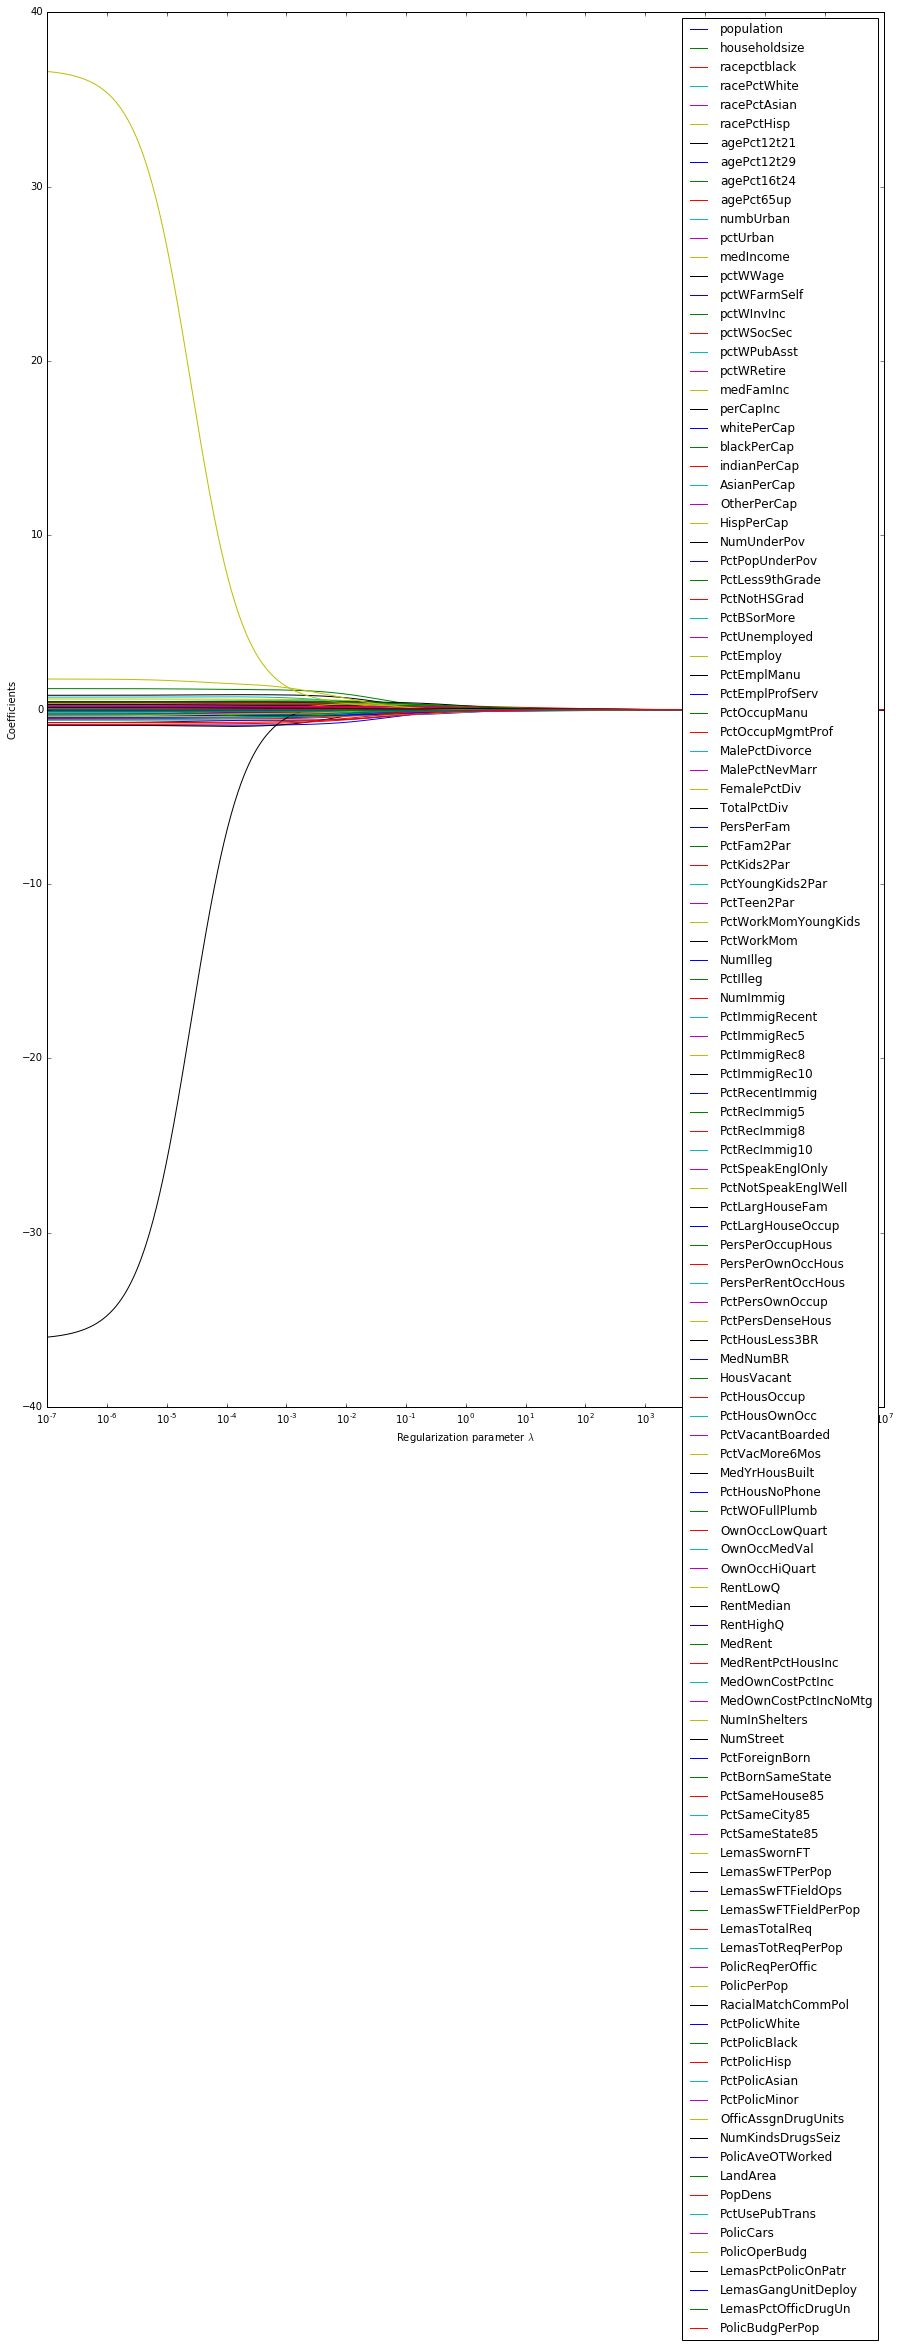

In [51]:
plt.figure(figsize=(15,25))
h=plt.semilogx(10**lambdas, coeff_a);
plt.ylabel("Coefficients")
plt.xlabel(r'Regularization parameter $\lambda$')
plt.legend(h, X.columns.values)
plt.show()


From the figure above it is evident that as lambda value goes up all the coefficients are shrunk to a much smaller values, the drop in coefficient value is quite steep after lambda > 10^-5. Before the value of lambda was insignificant high coefficients values dominated regression model but as the lambda value increases beyond 10^3 some of coefficient values got a significantly drop close to zero and as the lambda approaches 1 some of the coefficients values are reduced to insignificant value.

Ridge Regression: max R^2 score on training set 0.762386892032
Ridge Regression: max R^2 score on test set 0.645270313138


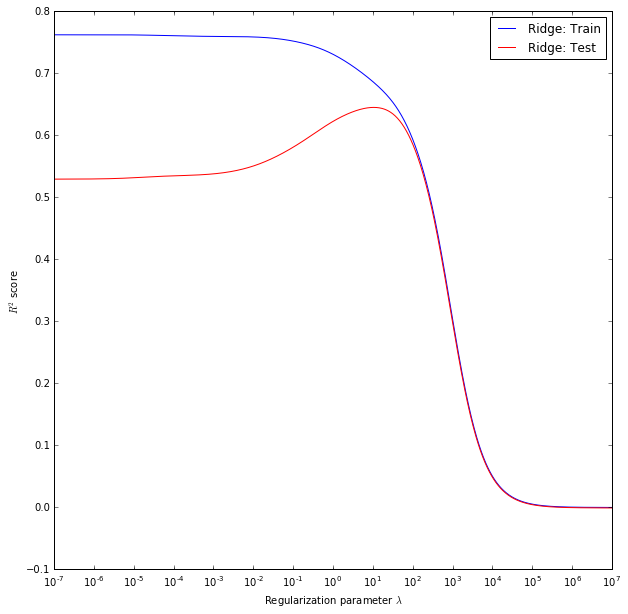

In [52]:
# Plot train an test R-squared as a function parameter value
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.semilogx(y = test_r_squared_plain, c='g', label = 'Plain Regression')
ax.semilogx(10.0**lambdas, (train_r_squared), c='b', label='Ridge: Train')
ax.semilogx(10.0**lambdas, (test_r_squared), c='r', label='Ridge: Test')


ax.set_xlabel('Regularization parameter $\lambda$')
ax.set_ylabel(r'$R^2$ score')

#ax.set_ylim((test_r_squared_plain-0.2, 1.2))
ax.legend(loc = 'best')

print 'Ridge Regression: max R^2 score on training set', max(train_r_squared)
print 'Ridge Regression: max R^2 score on test set', max(test_r_squared)

plt.show()

In [54]:
lambda_choice = 1000.0
reg = Ridge_Reg(alpha = lambda_choice)
reg.fit(X_train, y_train)

coefficients = reg.coef_
# Evaluate train & test performance
train_score = reg.score(X_train, y_train)
test_score = reg.score(X_test, y_test) 

print "Coeff:" , coefficients
print 'Predictors with non-zero coefficients:', [i for i, item in enumerate(coefficients) if abs(item) > 0.005]
print 'Ridge: R^2 score on training set', reg.score(X_train,y_train)
print 'Ridge Regression: R^2 score on test set', reg.score(X_test,y_test)
#[2, 3, 11, 15, 34, 38, 40, 41, 43, 44, 45, 46, 50, 72, 90, 116]
#[2, 3, 12, 15, 17, 19, 28, 29, 30, 32, 38, 40, 41, 43, 44, 45, 46, 50, 58, 59, 62, 67, 68, 69, 70, 71, 73, 74, 77, 78, 98, 104, 105, 111, 118, 119, 120]
#[2, 28, 38, 45, 53, 68, 71, 82, 85, 86, 90, 106, 121]

Coeff: [  3.43850074e-03  -5.03042842e-04   1.32065342e-02  -1.36542680e-02
   2.23523552e-03   4.78039224e-03   3.82819186e-04   1.60656533e-03
   1.31524209e-03   7.94124109e-04   3.44087950e-03   3.58228856e-03
  -5.66523590e-03  -3.63709770e-03  -3.47315413e-03  -7.13566135e-03
   1.10051252e-03   8.54085390e-03  -1.44202226e-03  -5.47109024e-03
  -3.86951153e-03  -1.70956967e-03  -2.28488940e-03  -2.97980402e-04
  -1.70932963e-03  -4.11968253e-04  -2.21080555e-03   4.00992699e-03
   8.14619136e-03   5.47951117e-03   6.36314165e-03  -3.93079405e-03
   6.86859359e-03  -3.93066642e-03  -7.05135514e-04  -7.96236342e-04
   3.76442491e-03  -3.78297675e-03   7.97700827e-03   3.86076937e-03
   7.70055070e-03   8.17306128e-03   1.30312602e-03  -1.06865409e-02
  -1.14244812e-02  -1.10133483e-02  -9.68835335e-03   1.65525782e-05
  -1.53936605e-03   3.51872791e-03   1.32805583e-02   2.04610544e-03
   3.19440744e-03   3.21783986e-03   3.95727366e-03   4.64964444e-03
   4.58819198e-03   4.79033

In [55]:
for ind, i in enumerate(lambdas):    
    # Fit ridge regression on train set
    reg = Lasso_Reg(alpha = 10**i)
    reg.fit(X_train, y_train)
       
    coeff_a[ind,:] = reg.coef_
    # Evaluate train & test performance
    train_r_squared[ind] = reg.score(X_train, y_train)
    test_r_squared[ind] = reg.score(X_test, y_test)   

Lasso Regression: max R^2 score on training set 0.759565433573
Lasso Regression: max R^2 score on test set 0.643625221788


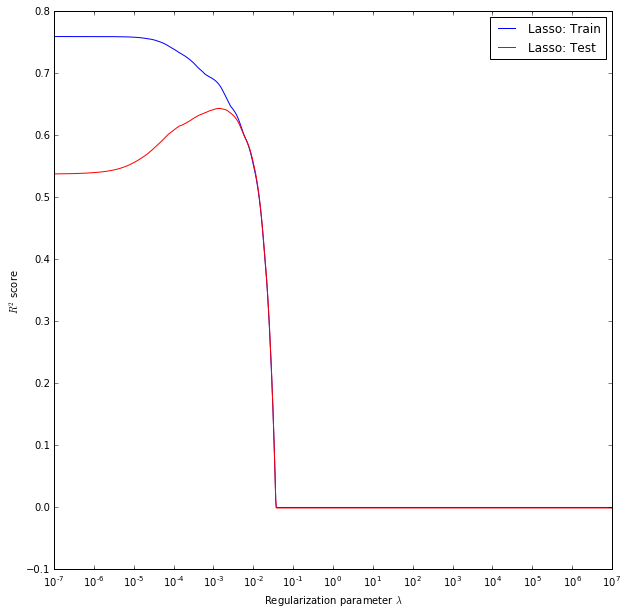

In [56]:
# Plot train an test R-squared as a function parameter value
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.semilogx(y = test_r_squared_plain, c='g', label = 'Plain Regression')
ax.semilogx(10.0**lambdas, (train_r_squared), c='b', label='Lasso: Train')
ax.semilogx(10.0**lambdas, (test_r_squared), c='r', label='Lasso: Test')


ax.set_xlabel('Regularization parameter $\lambda$')
ax.set_ylabel(r'$R^2$ score')

#ax.set_ylim((test_r_squared_plain-0.2, 1.2))
ax.legend(loc = 'best')

print 'Lasso Regression: max R^2 score on training set', max(train_r_squared)
print 'Lasso Regression: max R^2 score on test set', max(test_r_squared)

plt.show()

In [58]:
lambda_choise = 0.01
reg = Lasso_Reg(alpha =lambda_choise)
reg.fit(X_train, y_train)
coefficients = reg.coef_

print "Coeff:" , coefficients
print 'Predictors with non-zero coefficients:', [i for i, item in enumerate(coefficients) if abs(item) > 0.005]
print 'Lasso Regression: R^2 score on training set', reg.score(X_train,y_train)
print 'Lasso Regression: R^2 score on test set', reg.score(X_test,y_test)
#[   3, 30,   38,     44,     50,         71,   72, 89,              101]
#[   3,       38,     44, 48, 50,     68, 71, 74,    77, 88, 90, 102]
#[2, 3, 11, 34, 40,   44,     50, 59, 68,       72,          90,     101, 116]
#[   3,               44,     50,                              98](3,44,50,98)
#{   3,       38      44      50      68  71    72           90       101}(3,44,50)

Coeff: [ 0.         -0.          0.         -0.22587286  0.          0.         -0.
  0.         -0.          0.          0.          0.         -0.         -0.
 -0.         -0.          0.          0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.          0.         -0.          0.
  0.          0.          0.         -0.          0.         -0.         -0.
 -0.          0.         -0.          0.          0.          0.          0.
  0.         -0.         -0.2032837  -0.         -0.         -0.         -0.
  0.          0.13380372  0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.          0.          0.
  0.         -0.         -0.          0.         -0.          0.          0.
 -0.          0.         -0.         -0.          0.         -0.         -0.
  0.          0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.          0.          0.         -0.          0.     


As we have substantially large (127) predictors in this problem the normal multivariate regression end up having a significant increase in variance even though the bias has decreased due to better model fit with the train data, where we noticed that the R^2 score is close to 1.0. However at the same time the test R^2 score plummeted to deplorable value and some times it became negative indicating plain regression on test data has become arbitrarily worse.

In contrast the test R^2 scores for test data improved using ridge regression. This has been plotted in the figure above showing as the value of lambda is increased from 10^-3 to 0.1, where max R^2 score of 0.94 for test data became as good as that of R^2 score of 0.9997 on train data. This is direct result of reducing some coefficients to near zero as lambda increases thus reducing the overfitting (getting optimal bias and variance) of the model and optimizes the model for better fit. 

### Tune regularization parameter using cross-validation and bootstrapping
-  Evaluate the performance of the Ridge regression for different regularization parameters $\lambda$ using 5-fold cross validation **or** bootstrapping on the training set. 

    - Plot the cross-validation (CV) or bootstrapping R^2 score as a function of $\lambda$. 
    
    - How closely does the CV score or bootstrapping score match the R^2 score on the test set? Does the model with lowest CV score or bootstrapping score correspond to the one with maximum R^2 on the test set?
    
    - Does the model chosen by CV or bootstrapping perform better than plain linear regression?

**Note**: Using the `statsmodels` or `sklearn` to fit a linear regression model and evaluate the fits. Also using `kFold` from `sklearn.cross_validation`. 

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


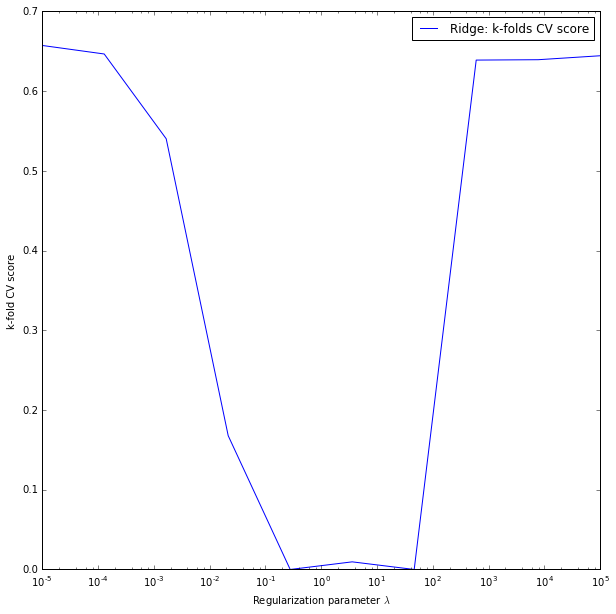

In [59]:
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn import svm

n_folds=5

lambda_min = -5
lambda_max = 5

num_lambdas = 10

lambdas= np.linspace(lambda_min,lambda_max, num_lambdas)

k_fol_scores = np.zeros(num_lambdas)
test_r_squared_c = np.zeros(num_lambdas)

#for i in range(n_folds):    
#    k_fol_scores[i] = np.zeros(num_lambdas)

for ind, i in enumerate(lambdas):    
    # Fit ridge regression on train set
    reg = Ridge_Reg(alpha = 10**i)
    reg.fit(X_train, y_train)
    
    test_r_squared_c[ind] = reg.score(X_test, y_test)       
    
    k_fold = KFold(y.shape[0], n_folds, shuffle=True, random_state=0)
    some_value =  cross_val_score(reg, X, y, cv=k_fold, n_jobs=1)
    k_fol_scores[i] =  some_value.mean()
       
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.semilogx(y = test_r_squared_plain, c='g', label = 'Plain Regression')
ax.semilogx(10.0**lambdas, (k_fol_scores), c='b', label='Ridge: k-folds CV score')
#ax.semilogx(10.0**lambdas, (test_r_squared_c), c='r', label='Ridge: test score')


ax.set_xlabel('Regularization parameter $\lambda$')
ax.set_ylabel(r'k-fold CV score')

ax.legend(loc = 'best')

plt.show()


In [60]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score

reg = Ridge_Reg(alpha = 0.000000001)
reg.fit(X_train, y_train)

k_fold = KFold(y.shape[0], n_folds=4, shuffle=True, random_state=0)
#clf = <any classifier>

print cross_val_score(reg, X, y, cv=k_fold, n_jobs=1)

[ 0.644418    0.59470186  0.65639859  0.64605485]


In [61]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn import svm
y_train_typed= y_train.astype('int')
k_fold = KFold(y.shape[0], n_folds=2, shuffle=True, random_state=0)
clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train_typed)
y_typed= y.astype('int')
print cross_val_score(clf, X, y_typed, cv=k_fold, n_jobs=1)

[ 0.97492477  0.97291876]


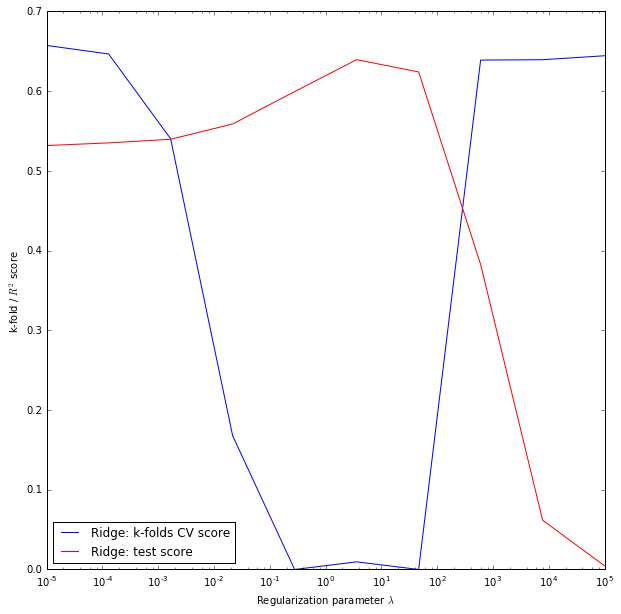

In [62]:
      
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.semilogx(y = test_r_squared_plain, c='g', label = 'Plain Regression')
ax.semilogx(10.0**lambdas, (k_fol_scores), c='b', label='Ridge: k-folds CV score')
ax.semilogx(10.0**lambdas, (test_r_squared_c), c='r', label='Ridge: test score')


ax.set_xlabel('Regularization parameter $\lambda$')
ax.set_ylabel(r'k-fold / $R^2$ score')

ax.legend(loc = 'best')

plt.show()



The k-fold score is shown as Blue line in chart above and R^2 score of test data using the test set is shown in red. The k-fold score is very high for certan type of lambda values.


Looking at the chart the test score and k-fold optimze on certain range of values of lambda only.


CV model performed very well for optimized choices of lambda and it seems to result very consistent behavior.

In [16]:
pd_auto_cate.head(1)

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.9,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.2,0.06,0.04,0.9,0.5,0.32,0.14,0.2


In [18]:
pd_auto_cate.iloc[:,0].values
#{   3,       38      44      50      68  71    72           90       101}(3,44,50)

array([ 0.19,  0.  ,  0.  , ...,  0.16,  0.08,  0.2 ])

In [43]:
arr = [i for i in pd_auto_cate.columns ]
#print arr
##for index, key in enumerate(arr ):
##    print index, key
#print [k for (k, v) in enumerate(arr )]
print [ '['+str(index)+']= '+key for index, key in enumerate(arr )]

['[0]= population', '[1]= householdsize', '[2]= racepctblack', '[3]= racePctWhite', '[4]= racePctAsian', '[5]= racePctHisp', '[6]= agePct12t21', '[7]= agePct12t29', '[8]= agePct16t24', '[9]= agePct65up', '[10]= numbUrban', '[11]= pctUrban', '[12]= medIncome', '[13]= pctWWage', '[14]= pctWFarmSelf', '[15]= pctWInvInc', '[16]= pctWSocSec', '[17]= pctWPubAsst', '[18]= pctWRetire', '[19]= medFamInc', '[20]= perCapInc', '[21]= whitePerCap', '[22]= blackPerCap', '[23]= indianPerCap', '[24]= AsianPerCap', '[25]= OtherPerCap', '[26]= HispPerCap', '[27]= NumUnderPov', '[28]= PctPopUnderPov', '[29]= PctLess9thGrade', '[30]= PctNotHSGrad', '[31]= PctBSorMore', '[32]= PctUnemployed', '[33]= PctEmploy', '[34]= PctEmplManu', '[35]= PctEmplProfServ', '[36]= PctOccupManu', '[37]= PctOccupMgmtProf', '[38]= MalePctDivorce', '[39]= MalePctNevMarr', '[40]= FemalePctDiv', '[41]= TotalPctDiv', '[42]= PersPerFam', '[43]= PctFam2Par', '[44]= PctKids2Par', '[45]= PctYoungKids2Par', '[46]= PctTeen2Par', '[47]= 

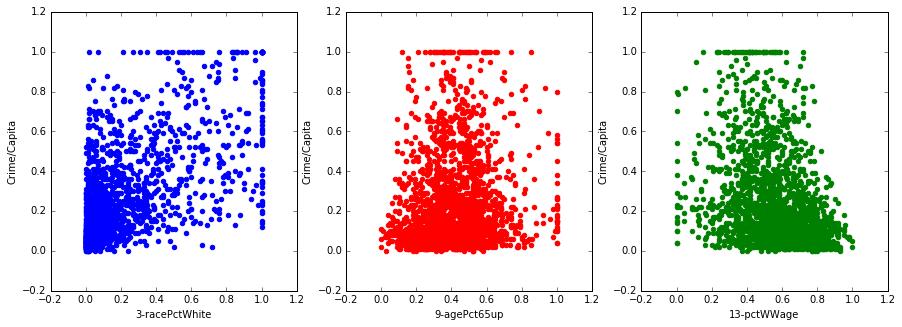

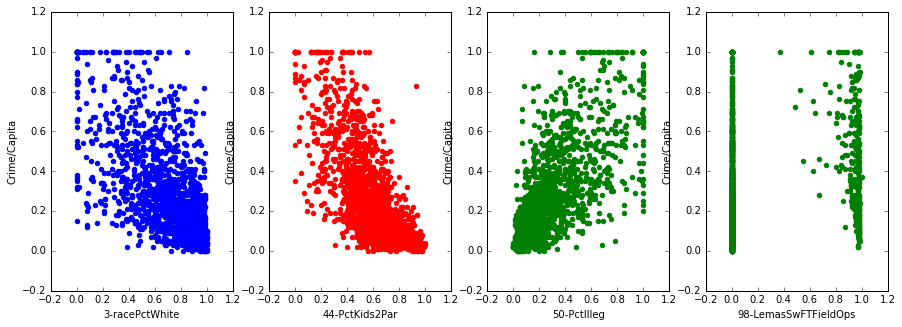

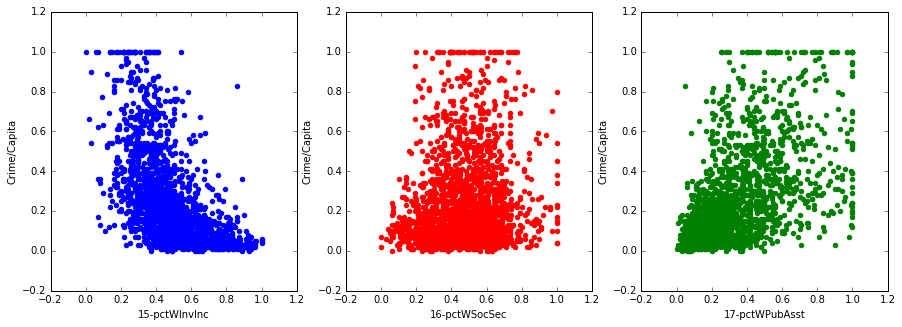

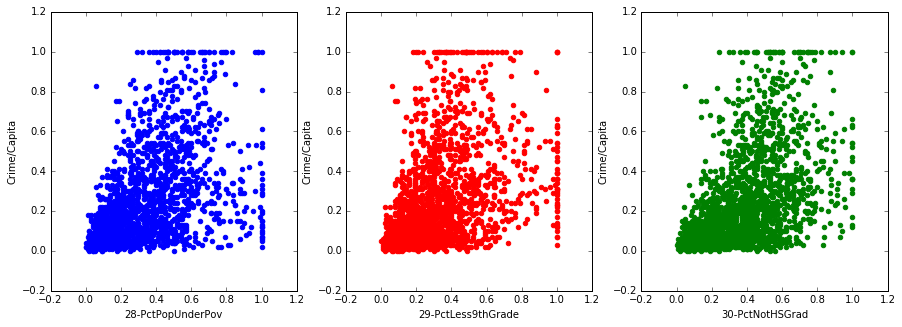

In [52]:
#The relevant coefficients scatter plots
#{   3,       38      44      50      68  71    72           90       101}(3,44,509
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.scatter(pd_auto_cate.iloc[:,2].values,pd_auto_cate.iloc[:,-1].values,color='blue')
ax2.scatter(pd_auto_cate.iloc[:,9].values,pd_auto_cate.iloc[:,-1].values,color='red')
ax3.scatter(pd_auto_cate.iloc[:,13].values,pd_auto_cate.iloc[:,-1].values,color='green')
ax1.set_xlabel('3-racePctWhite'); ax1.set_ylabel('Crime/Capita')
ax2.set_xlabel('9-agePct65up'); ax2.set_ylabel('Crime/Capita')
ax3.set_xlabel('13-pctWWage'); ax3.set_ylabel('Crime/Capita')
plt.legend(loc='best')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))
ax1.scatter(pd_auto_cate.iloc[:,3].values,pd_auto_cate.iloc[:,-1].values,color='blue')
ax2.scatter(pd_auto_cate.iloc[:,44].values,pd_auto_cate.iloc[:,-1].values,color='red')
ax3.scatter(pd_auto_cate.iloc[:,50].values,pd_auto_cate.iloc[:,-1].values,color='green')
ax4.scatter(pd_auto_cate.iloc[:,98].values,pd_auto_cate.iloc[:,-1].values,color='green')
ax1.set_xlabel('3-racePctWhite'); ax1.set_ylabel('Crime/Capita')
ax2.set_xlabel('44-PctKids2Par'); ax2.set_ylabel('Crime/Capita')
ax3.set_xlabel('50-PctIlleg'); ax3.set_ylabel('Crime/Capita')
ax4.set_xlabel('98-LemasSwFTFieldOps'); ax4.set_ylabel('Crime/Capita')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.scatter(pd_auto_cate.iloc[:,15].values,pd_auto_cate.iloc[:,-1].values,color='blue')
ax2.scatter(pd_auto_cate.iloc[:,16].values,pd_auto_cate.iloc[:,-1].values,color='red')
ax3.scatter(pd_auto_cate.iloc[:,17].values,pd_auto_cate.iloc[:,-1].values,color='green')
ax1.set_xlabel('15-pctWInvInc'); ax1.set_ylabel('Crime/Capita')
ax2.set_xlabel('16-pctWSocSec'); ax2.set_ylabel('Crime/Capita')
ax3.set_xlabel('17-pctWPubAsst'); ax3.set_ylabel('Crime/Capita')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.scatter(pd_auto_cate.iloc[:,28].values,pd_auto_cate.iloc[:,-1].values,color='blue')
ax2.scatter(pd_auto_cate.iloc[:,29].values,pd_auto_cate.iloc[:,-1].values,color='red')
ax3.scatter(pd_auto_cate.iloc[:,30].values,pd_auto_cate.iloc[:,-1].values,color='green')
ax1.set_xlabel('28-PctPopUnderPov'); ax1.set_ylabel('Crime/Capita')
ax2.set_xlabel('29-PctLess9thGrade'); ax2.set_ylabel('Crime/Capita')
ax3.set_xlabel('30-PctNotHSGrad'); ax3.set_ylabel('Crime/Capita')


plt.show()